In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install feature_engine
!pip uninstall scikit-learn --yes
!pip uninstall imblearn --yes
!pip install scikit-learn==1.2.2
!pip install imblearn
!pip install scikit-plot

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from feature_engine.imputation import ArbitraryNumberImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
import scikitplot as skplt

In [5]:
df = pd.read_csv("/content/drive/MyDrive/Machine Learning/ETL-ML-Dengue/data/data_2000_2019.csv", sep=',')

colunas_escolhidas = ['micro_code','month','year', 'time', 'dengue_cases', 'population', 'pop_density', 'tmax',
                      'tmin', 'pdsi', 'urban', 'water_network', 'water_shortage']

df_filtrado = df[colunas_escolhidas].copy()

df_filtrado_dropado = df_filtrado.dropna(subset=['dengue_cases', 'population'])

df_filtrado_dropado['maior_que_300'] = (((df_filtrado_dropado['dengue_cases']/df_filtrado_dropado['population'])*100_000)>300)

df_filtrado_dropado = df_filtrado_dropado.sort_values(by=['micro_code', 'time'])

df_filtrado_dropado['maior_que_300_30d'] = df_filtrado_dropado.groupby('micro_code')['maior_que_300'].shift(-2)

print(df_filtrado_dropado)


        micro_code  month  year  time  dengue_cases  population  pop_density  \
6696         11001      1  2001    13         267.0    426640.0     6.503234   
7254         11001      2  2001    14          67.0    426640.0     6.503234   
7812         11001      3  2001    15          60.0    426640.0     6.503234   
8370         11001      4  2001    16          35.0    426640.0     6.503234   
8928         11001      5  2001    17          62.0    426640.0     6.503234   
...            ...    ...   ...   ...           ...         ...          ...   
131687       53001      8  2019   236         502.0   3015268.0   521.289159   
132245       53001      9  2019   237         491.0   3015268.0   521.289159   
132803       53001     10  2019   238         560.0   3015268.0   521.289159   
133361       53001     11  2019   239         532.0   3015268.0   521.289159   
133919       53001     12  2019   240         576.0   3015268.0   521.289159   

             tmax       tmin      pdsi 

<ipython-input-5-5b6014c7ec11>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado_dropado['maior_que_300'] = (((df_filtrado_dropado['dengue_cases']/df_filtrado_dropado['population'])*100_000)>300)


In [6]:
temp_df = df_filtrado_dropado.dropna(subset=["maior_que_300_30d"]).copy()

temp_df['date'] = pd.to_datetime(temp_df[['year', 'month']].assign(day=1))

temp_df['maior_que_300_30d'] = temp_df['maior_que_300_30d'].astype(int)


In [7]:
# Defina as datas de início e fim para o filtro
start_date = '2000-01-01'
end_date = '2016-12-01'

# Filtrar o DataFrame entre as duas datas
filtered_df = temp_df.loc[(temp_df['date'] >= start_date) & (temp_df['date'] <= end_date)]

print(filtered_df)

        micro_code  month  year  time  dengue_cases  population  pop_density  \
6696         11001      1  2001    13         267.0    426640.0     6.503234   
7254         11001      2  2001    14          67.0    426640.0     6.503234   
7812         11001      3  2001    15          60.0    426640.0     6.503234   
8370         11001      4  2001    16          35.0    426640.0     6.503234   
8928         11001      5  2001    17          62.0    426640.0     6.503234   
...            ...    ...   ...   ...           ...         ...          ...   
111599       53001      8  2016   200          96.0   2977216.0   514.710607   
112157       53001      9  2016   201          86.0   2977216.0   514.710607   
112715       53001     10  2016   202          79.0   2977216.0   514.710607   
113273       53001     11  2016   203         108.0   2977216.0   514.710607   
113831       53001     12  2016   204         378.0   2977216.0   514.710607   

             tmax       tmin      pdsi 

In [8]:
# Defina as datas de início e fim para o filtro
start_date = '2016-12-01'
end_date = '2017-01-01'

# Filtrar o DataFrame entre as duas datas
oot = temp_df.loc[(temp_df['date'] >= start_date) & (temp_df['date'] <= end_date)]

X_oot = oot.drop(["micro_code","month","year","time","dengue_cases","population",
                  "pop_density", "maior_que_300","maior_que_300_30d", "date"], axis=1)
y_oot = oot["maior_que_300_30d"]

In [9]:
X = filtered_df.drop(["micro_code","month","year","time","dengue_cases","population",
                  "pop_density", "maior_que_300","maior_que_300_30d", "date"], axis=1)
y = filtered_df["maior_que_300_30d"]


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [11]:
X_train.isna().sum()

tmax                0
tmin                0
pdsi              145
urban               0
water_network       0
water_shortage      0
dtype: int64

In [12]:
# Crie uma instância do RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)

# Aplique o undersampling aos seus dados
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

In [13]:
pipeline = Pipeline(
    [
        ('arbitrary_number_imputer', ArbitraryNumberImputer(arbitrary_number=-999)),
        ('scaler', MinMaxScaler()),

    ]
)

In [14]:
# Aplicar o Pipeline nos dados de treino
X_train_transformed = pipeline.fit_transform(X_resampled)

# Aplicar o Pipeline nos dados de teste
X_test_transformed = pipeline.transform(X_test)

# Aplicar o Pipeline nos dados de out of time
X_oot_transformed = pipeline.transform(X_oot)

In [15]:
dic_contagem = Counter(y_resampled)
print(dic_contagem[1]/(dic_contagem[1]+dic_contagem[0]))

0.5


In [16]:
# Criar e treinar o modelo de árvore de decisão
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_transformed, y_resampled)

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test_transformed)

In [17]:
# Calcular a acurácia do modelo
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia do modelo: {:.2f}%".format(accuracy * 100))

Acurácia do modelo: 76.56%


In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plotMatrix(y_test, y_pred, labels = ["< 300", ">= 300"], figName = "ConfusionMatrix"):

  conf_matrix = confusion_matrix(y_test, y_pred)
  conf_matrix_percent = conf_matrix / np.sum(conf_matrix, axis=1, keepdims=True)

  # Configuração do gráfico
  class_names = labels
  sns.set(font_scale=1.2)
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix_percent, annot=False, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar=False)
  for i in range(len(class_names)):
      for j in range(len(class_names)):
          if conf_matrix_percent[i, j] > 0.7:
            color = "white"
          else:
            color="black"
          plt.text(j + 0.5, i + 0.5, f"{conf_matrix_percent[i, j]:.2%}\n({conf_matrix[i, j]})", ha="center", va="center", color=color)

  plt.title("Predição de casos/100mil hab.")
  plt.xlabel('Predicted Values')
  plt.ylabel('Real Values')
  plt.savefig(f'{figName}.png', dpi=300)
  plt.show()

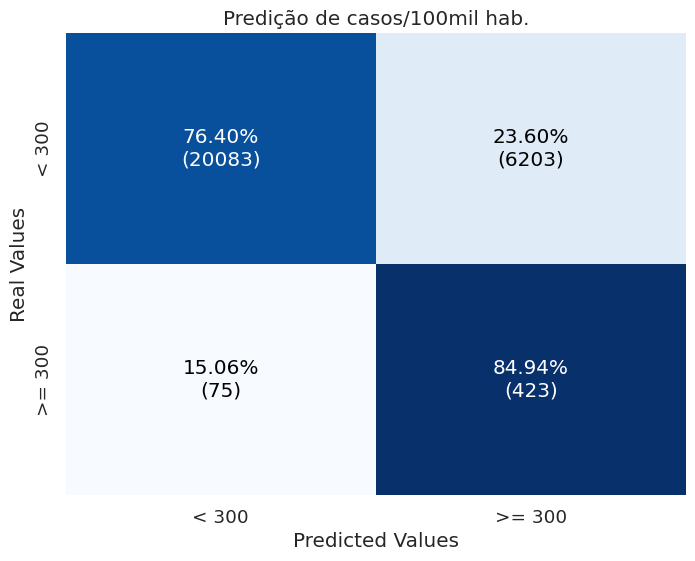

In [19]:
plotMatrix(y_test, y_pred)

In [20]:
from sklearn.metrics import roc_curve

# Probabilidades previstas pelo modelo
y_proba = model.predict_proba(X_test_transformed)[:,1]

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_test.values, y_proba)

# Calcular KS1
ks = np.max(np.abs(tpr - fpr))

# Encontrar o melhor ponto de corte
best_threshold = thresholds[np.argmax(np.abs(tpr - fpr))]

print("KS1:", ks)
print("Melhor ponto de corte:", best_threshold)

KS1: 0.6259935885977144
Melhor ponto de corte: 0.56


<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

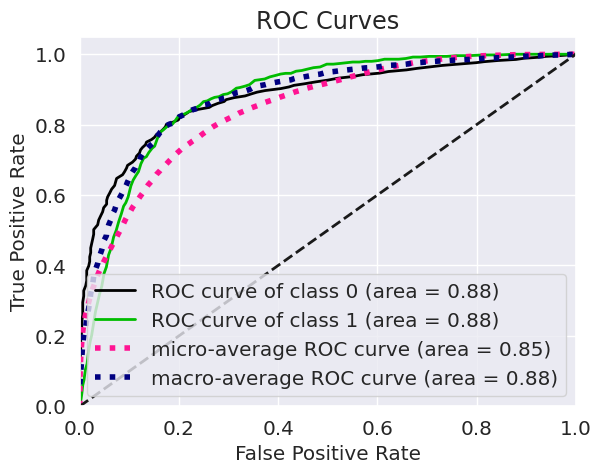

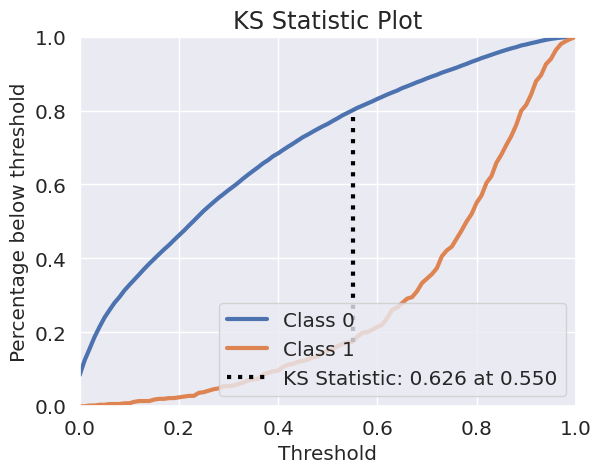

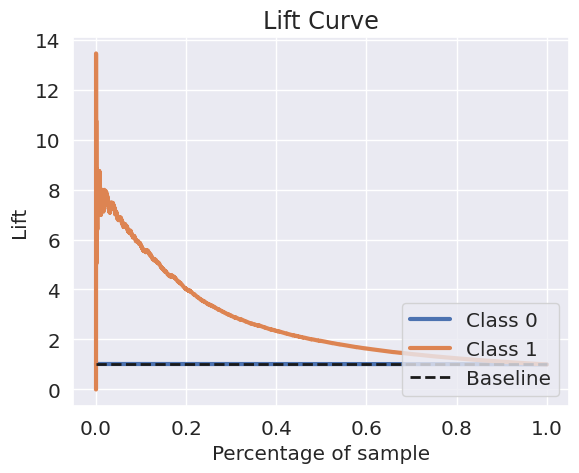

In [21]:
y_probas = model.predict_proba(X_test_transformed)
skplt.metrics.plot_roc(y_test, y_probas)
skplt.metrics.plot_ks_statistic(y_test, y_probas)
skplt.metrics.plot_lift_curve(y_test, y_probas)

In [22]:

y_pred_oot = model.predict(X_oot_transformed)
# Calcular a acurácia do modelo
accuracy_oot = accuracy_score(y_oot, y_pred_oot)
print("Acurácia do modelo: {:.2f}%".format(accuracy_oot * 100))

Acurácia do modelo: 50.99%


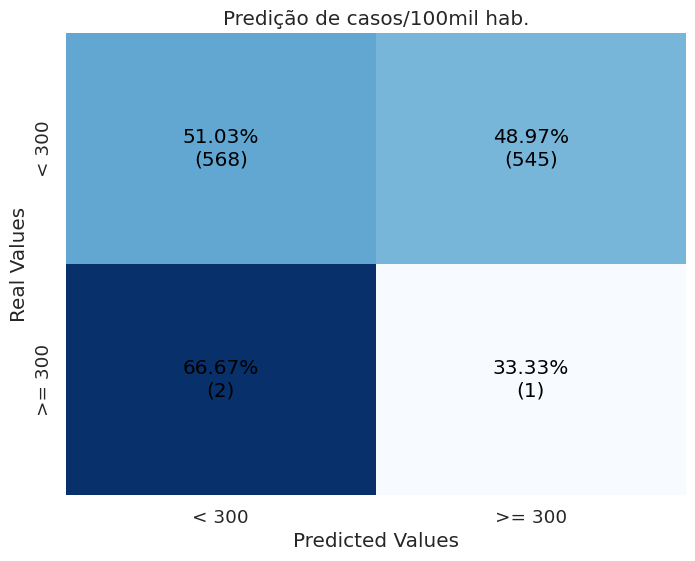

In [23]:
plotMatrix(y_oot, y_pred_oot)

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

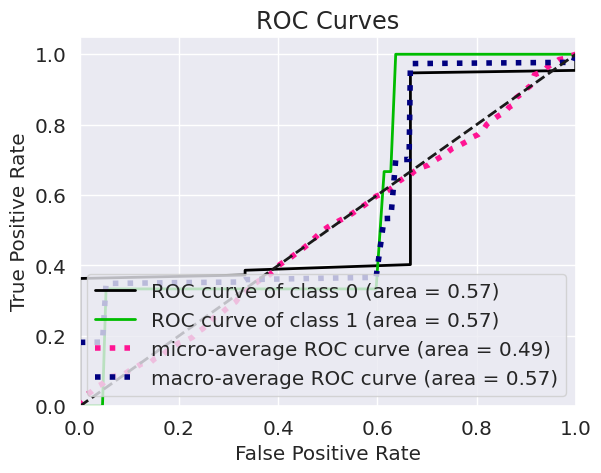

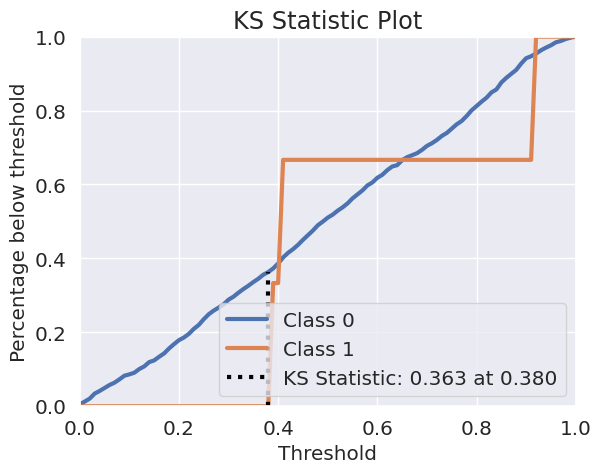

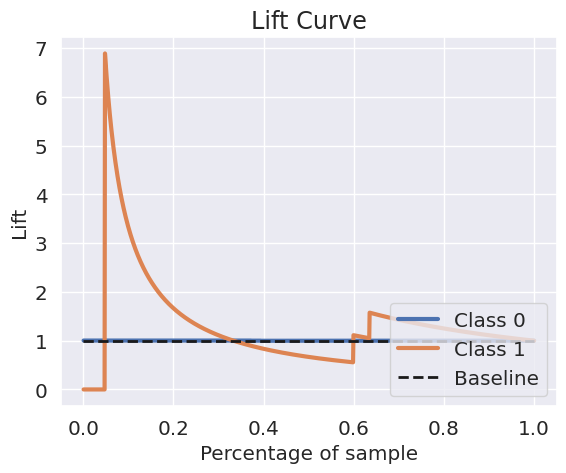

In [24]:
y_probas_oot = model.predict_proba(X_oot_transformed)
skplt.metrics.plot_roc(y_oot, y_probas_oot)
skplt.metrics.plot_ks_statistic(y_oot, y_probas_oot)
skplt.metrics.plot_lift_curve(y_oot, y_probas_oot)

In [25]:
max(temp_df['date'])

Timestamp('2019-10-01 00:00:00')

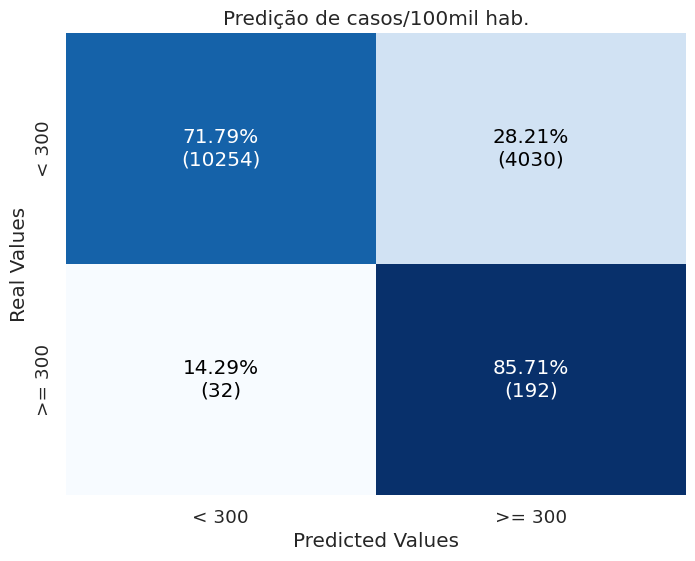

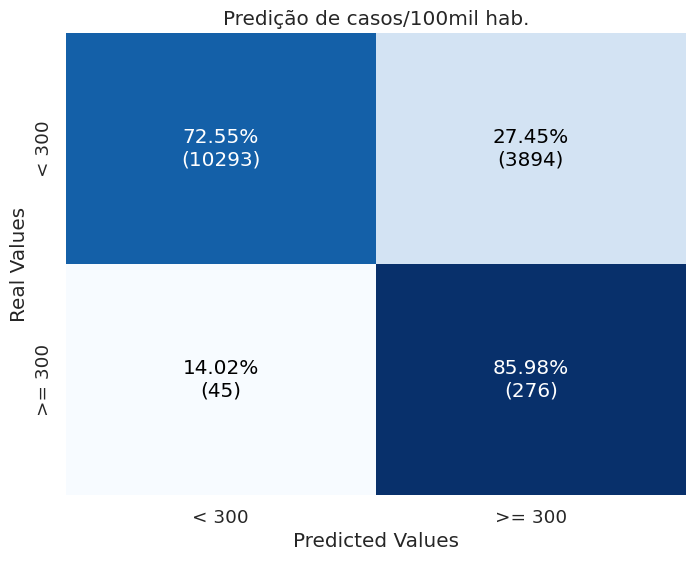

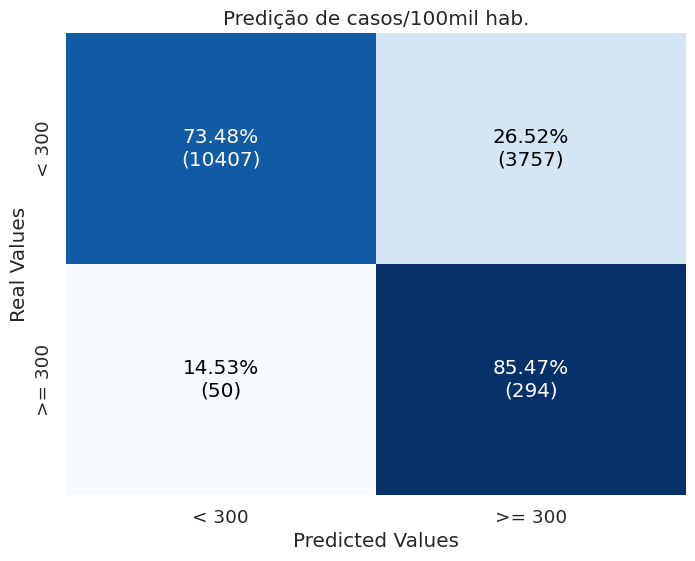

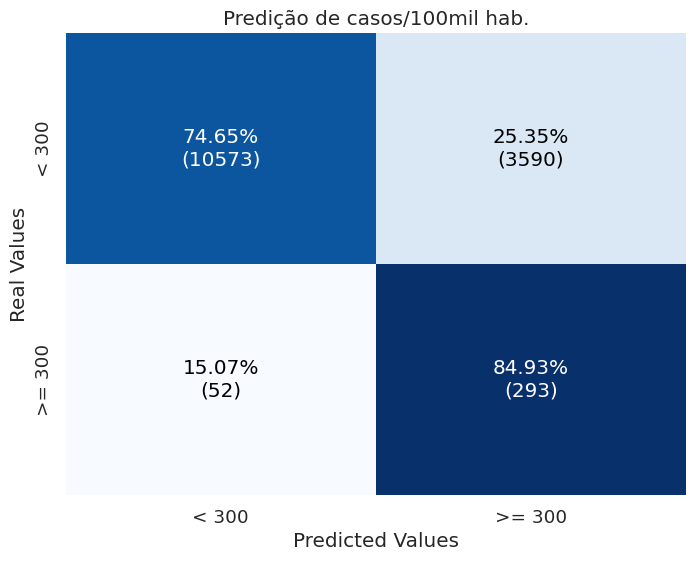

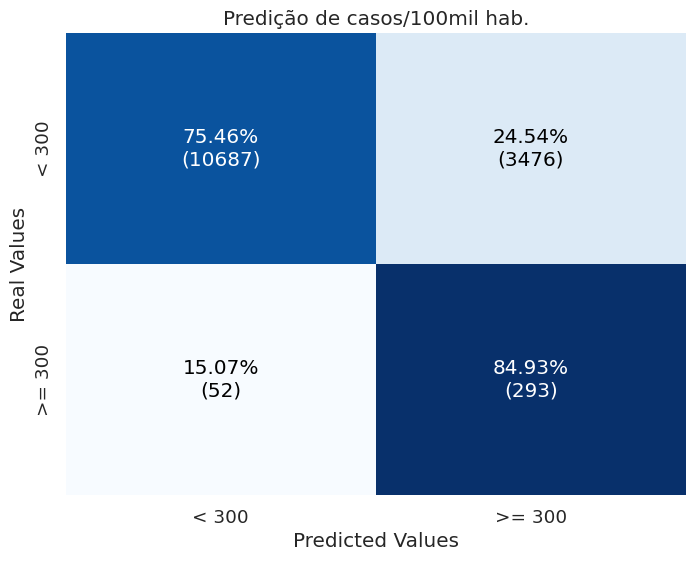

  Data Predição Data Predita  Acurácia  Precision    Recall        F1
0    2024-04-25   31-01-2017  0.720017   0.045476  0.857143  0.086370
1    2024-04-25   28-02-2017  0.728495   0.066187  0.859813  0.122912
2    2024-04-25   31-03-2017  0.737593   0.072575  0.854651  0.133788
3    2024-04-25   30-04-2017  0.748966   0.075457  0.849275  0.138600
4    2024-04-25   31-05-2017  0.756824   0.077739  0.849275  0.142440


In [46]:
import datetime
import pandas as pd

# initializing date
start_date = "01-01-2017"

# initializing K
n_meses = 30

date_generated = pd.date_range(start_date, periods=n_meses, freq='M')

dic_predicoes = {
    'Data Predição':[],
    'Data Predita':[],
    'Acurácia':[],
    'Precision':[],
    'Recall':[],
    'F1':[],
    # 'ROC score':[]
}

pulo_meses = 25
lista_datas = date_generated.strftime("%d-%m-%Y")
for i in range(len(lista_datas)-pulo_meses):

  end_date = lista_datas[i+pulo_meses]

  oot = temp_df.loc[(temp_df['date'] >= start_date) & (temp_df['date'] <= end_date)]

  start_date = lista_datas[i]

  X_oot = oot.drop(["micro_code","month","year","time","dengue_cases","population",
                  "pop_density", "maior_que_300","maior_que_300_30d", "date"], axis=1)
  y_oot = oot["maior_que_300_30d"]

  # Aplicar o Pipeline nos dados de out of time
  X_oot_transformed = pipeline.transform(X_oot)

  y_pred_oot = model.predict(X_oot_transformed)
  y_probas_oot = model.predict_proba(X_oot_transformed)

  # print(start_date)

  # Calcular a acurácia
  accuracy = accuracy_score(y_oot, y_pred_oot)
  # Calcular a precisão
  precision = precision_score(y_oot, y_pred_oot)
  # Calcular o recall
  recall = recall_score(y_oot, y_pred_oot)
  # Calcular o F1-score
  f1 = f1_score(y_oot, y_pred_oot)
  # Calcular a área sob a curva ROC (AUC)
  # auc = roc_auc_score(y_oot, y_probas_oot[:,1])

  dic_predicoes['Data Predição'].append(datetime.datetime.now().strftime("%Y-%m-%d"))
  dic_predicoes['Data Predita'].append(start_date)
  dic_predicoes['Acurácia'].append(accuracy)
  dic_predicoes['Precision'].append(precision)
  dic_predicoes['Recall'].append(recall)
  dic_predicoes['F1'].append(f1)
  # dic_predicoes['ROC score'].append(auc)
  plotMatrix(y_oot, y_pred_oot)



df_previsoes = pd.DataFrame(dic_predicoes)

print(df_previsoes)